### This jupyter notebook employs a fully connective neural network(FC) or its alias artificial neural network (ANN) to learn the mapping between input current configuration between output magnetic field 

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import torch
from early_stopping import EarlyStopping

if torch.cuda.device_count():
    device = 'cuda'
    use_gpu = True
    print('Good to go')
else:
    device = 'cpu'
    use_gpu = False
    print('Using cpu')

Using cpu


/home/qubot/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
from ReadData import ReadCurrentAndField 
import glob
import os 

# print(os.getcwd())
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
#data = ReadFolder(foldername,filepattern)
load_file_num = 1460
train_file_num = 1000
grid_size = 21
data = ReadCurrentAndField (foldername,filepattern, load_file_num)


data=data.reshape(load_file_num,grid_size,grid_size,grid_size,18)
mask = torch.cat((torch.ones(1,1,1,1,12),1e3*torch.ones(1,1,1,1,6)), dim=4)
# position unit mm, B field unit mT, Current unit Ampere
data = mask*data

sparsity = 4

Current_position =data[:train_file_num,0::sparsity,0::sparsity,0::sparsity,:15].reshape(-1,15) # position unit mm
Bfield = data[:train_file_num,0::sparsity,0::sparsity,0::sparsity,15:].reshape(-1,3) # B field unit mT

print(data.shape)
print(data[:train_file_num,0::sparsity,0::sparsity,0::sparsity,:15].shape)
print('position shape', Current_position.shape)
print('Bfield shape', Bfield.shape)


torch.Size([1460, 21, 21, 21, 18])
torch.Size([1000, 6, 6, 6, 15])
position shape torch.Size([216000, 15])
Bfield shape torch.Size([216000, 3])


In [6]:
from Neural_network import NN_net, Plain_fc_block, weight_init, eMNS_Dataset
from Training_loop_v2 import train_ANN
from ray.train import RunConfig, ScalingConfig, CheckpointConfig
from ray.train.torch import TorchTrainer
from ray.tune.tuner import Tuner
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import ray, os
import torch.nn.functional as F

# construct dataset

Current_position =data[:train_file_num,0::sparsity,0::sparsity,0::sparsity,:15].reshape(-1,15) # position unit mm

Bfield = data[:train_file_num,0::sparsity,0::sparsity,0::sparsity,15:].reshape(-1,3) # B field unit mT

dataset = eMNS_Dataset(
    x=Current_position,
    y=Bfield
)

# split the dataset to train, validation, test
train_set, valid_set = torch.utils.data.random_split(dataset, [0.9,0.1])

# normailzation
extremes = dataset.train_norm_ANN(train_indices = train_set.indices, boundary_index=12)

###############################################
# Config the neural network
###############################################
num_input = 15
num_output = 3
fc_stages = [(num_input,128,1),(128,64,1),(64,32,1)]
fc_network = NN_net(None,fc_stages,None,Plain_fc_block, num_output=num_output)

loss_func = lambda preds, y: F.l1_loss(preds, y)


################################################
# Train the neural network
################################################

train_loop_config = {
                'epochs': 50,
                'lr_max': 1e-3,
                'lr_min': 2.5e-6,
                'batch_size': 128,
                'L2_norm'   : 0,
                'verbose': False,
                'schedule': [],
                'learning_rate_decay': 0.5,
                'num_input'   : num_input,
                'num_output'  : num_output,
                'fc_stages'   : fc_stages,
                'backward'    : False,
                'maxB'        : extremes[4],
                'minB'        : extremes[5],
                'device'      : device,
                'train_set'   : train_set,
                'valid_set'   : valid_set,
                'loss_func'   : loss_func
                # You can even grid search various datasets in Tune.
                # "datasets": tune.grid_search(
                #         [ds1, ds2]
                #     ),
}

scaling_config = ScalingConfig(
    num_workers = 1,
    use_gpu = use_gpu,
    #resource_per_worker = {"CPU":1, "GPU":1}
)

run_config = RunConfig(name="EMS_ANN_v2", storage_path= "~/ray_results",checkpoint_config=CheckpointConfig(num_to_keep=1))

# def train_loop_per_worker(params):
#     train_GM(train_set=train_set, valid_set=valid_set,  device=device, config=params)

trainer = TorchTrainer(
    train_loop_per_worker = train_ANN,
    train_loop_config = train_loop_config,
    scaling_config = scaling_config,
    run_config = run_config,

)
result = trainer.fit()



(TorchTrainer pid=61919) Started distributed worker processes: 
(TorchTrainer pid=61919) - (ip=192.168.8.117, pid=61971) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=61971) Setting up process group for: env:// [rank=0, world_size=1]


(RayTrainWorker pid=61971) Epoch 0, Iteration 1519, loss = 0.0287
(RayTrainWorker pid=61971) Got rmse 2.382715940475464


(RayTrainWorker pid=61971) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/qubot/ray_results/EMS_ANN_v2/TorchTrainer_31192_00000_0_2024-04-18_18-05-32/checkpoint_000000)


(RayTrainWorker pid=61971) Got rmse 2.374053716659546
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 1, Iteration 3038, loss = 0.0242
(RayTrainWorker pid=61971) Got rmse 1.9738125801086426


2024-04-18 18:05:50,995	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.203 s, which may be a performance bottleneck.
2024-04-18 18:05:50,996	WARNING util.py:202 -- The `process_trial_result` operation took 2.204 s, which may be a performance bottleneck.
2024-04-18 18:05:50,998	WARNING util.py:202 -- Processing trial results took 2.206 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:05:50,998	WARNING util.py:202 -- The `process_trial_result` operation took 2.207 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 1.9707759618759155
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 2, Iteration 4557, loss = 0.0220
(RayTrainWorker pid=61971) Got rmse 1.7926974296569824


2024-04-18 18:05:55,376	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.011 s, which may be a performance bottleneck.
2024-04-18 18:05:55,377	WARNING util.py:202 -- The `process_trial_result` operation took 3.012 s, which may be a performance bottleneck.
2024-04-18 18:05:55,379	WARNING util.py:202 -- Processing trial results took 3.014 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:05:55,379	WARNING util.py:202 -- The `process_trial_result` operation took 3.015 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 1.7822023630142212
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 3, Iteration 6076, loss = 0.0196
(RayTrainWorker pid=61971) Got rmse 1.6796296834945679


2024-04-18 18:06:00,121	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.902 s, which may be a performance bottleneck.
2024-04-18 18:06:00,124	WARNING util.py:202 -- The `process_trial_result` operation took 2.905 s, which may be a performance bottleneck.
2024-04-18 18:06:00,125	WARNING util.py:202 -- Processing trial results took 2.906 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:06:00,125	WARNING util.py:202 -- The `process_trial_result` operation took 2.907 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 1.6662540435791016
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 4, Iteration 7595, loss = 0.0166


2024-04-18 18:06:04,092	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.931 s, which may be a performance bottleneck.
2024-04-18 18:06:04,094	WARNING util.py:202 -- The `process_trial_result` operation took 2.933 s, which may be a performance bottleneck.
2024-04-18 18:06:04,095	WARNING util.py:202 -- Processing trial results took 2.934 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:06:04,096	WARNING util.py:202 -- The `process_trial_result` operation took 2.935 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 1.519358515739441
(RayTrainWorker pid=61971) Got rmse 1.5031729936599731
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 5, Iteration 9114, loss = 0.0162
(RayTrainWorker pid=61971) Got rmse 1.5207393169403076


2024-04-18 18:06:08,899	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.929 s, which may be a performance bottleneck.
2024-04-18 18:06:08,903	WARNING util.py:202 -- The `process_trial_result` operation took 2.933 s, which may be a performance bottleneck.
2024-04-18 18:06:08,904	WARNING util.py:202 -- Processing trial results took 2.934 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:06:08,904	WARNING util.py:202 -- The `process_trial_result` operation took 2.934 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 1.5067219734191895
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 6, Iteration 10633, loss = 0.0171
(RayTrainWorker pid=61971) Got rmse 1.4295545816421509


2024-04-18 18:06:13,655	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.949 s, which may be a performance bottleneck.
2024-04-18 18:06:13,656	WARNING util.py:202 -- The `process_trial_result` operation took 2.951 s, which may be a performance bottleneck.
2024-04-18 18:06:13,658	WARNING util.py:202 -- Processing trial results took 2.952 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:06:13,658	WARNING util.py:202 -- The `process_trial_result` operation took 2.953 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 1.4119478464126587
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 7, Iteration 12152, loss = 0.0156
(RayTrainWorker pid=61971) Got rmse 1.3645905256271362


2024-04-18 18:06:17,513	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.842 s, which may be a performance bottleneck.
2024-04-18 18:06:17,517	WARNING util.py:202 -- The `process_trial_result` operation took 2.846 s, which may be a performance bottleneck.
2024-04-18 18:06:17,518	WARNING util.py:202 -- Processing trial results took 2.847 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:06:17,518	WARNING util.py:202 -- The `process_trial_result` operation took 2.848 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 1.3483092784881592
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 8, Iteration 13671, loss = 0.0150
(RayTrainWorker pid=61971) Got rmse 1.3102192878723145


2024-04-18 18:06:22,247	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.757 s, which may be a performance bottleneck.
2024-04-18 18:06:22,249	WARNING util.py:202 -- The `process_trial_result` operation took 2.760 s, which may be a performance bottleneck.
2024-04-18 18:06:22,250	WARNING util.py:202 -- Processing trial results took 2.761 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:06:22,251	WARNING util.py:202 -- The `process_trial_result` operation took 2.762 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 1.2950741052627563
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 9, Iteration 15190, loss = 0.0148
(RayTrainWorker pid=61971) Got rmse 1.2495125532150269


2024-04-18 18:06:26,185	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.829 s, which may be a performance bottleneck.
2024-04-18 18:06:26,189	WARNING util.py:202 -- The `process_trial_result` operation took 2.833 s, which may be a performance bottleneck.
2024-04-18 18:06:26,189	WARNING util.py:202 -- Processing trial results took 2.834 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:06:26,190	WARNING util.py:202 -- The `process_trial_result` operation took 2.835 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 1.2332062721252441
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 10, Iteration 16709, loss = 0.0164
(RayTrainWorker pid=61971) Got rmse 1.2134751081466675


2024-04-18 18:06:31,054	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.929 s, which may be a performance bottleneck.
2024-04-18 18:06:31,055	WARNING util.py:202 -- The `process_trial_result` operation took 2.930 s, which may be a performance bottleneck.
2024-04-18 18:06:31,057	WARNING util.py:202 -- Processing trial results took 2.932 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:06:31,058	WARNING util.py:202 -- The `process_trial_result` operation took 2.933 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 1.2009752988815308
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 11, Iteration 18228, loss = 0.0151
(RayTrainWorker pid=61971) Got rmse 1.1846833229064941


2024-04-18 18:06:35,209	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.972 s, which may be a performance bottleneck.
2024-04-18 18:06:35,214	WARNING util.py:202 -- The `process_trial_result` operation took 2.977 s, which may be a performance bottleneck.
2024-04-18 18:06:35,215	WARNING util.py:202 -- Processing trial results took 2.978 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:06:35,215	WARNING util.py:202 -- The `process_trial_result` operation took 2.979 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 1.1639429330825806
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 12, Iteration 19747, loss = 0.0135
(RayTrainWorker pid=61971) Got rmse 1.1696298122406006


2024-04-18 18:06:39,771	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.733 s, which may be a performance bottleneck.
2024-04-18 18:06:39,773	WARNING util.py:202 -- The `process_trial_result` operation took 2.735 s, which may be a performance bottleneck.
2024-04-18 18:06:39,774	WARNING util.py:202 -- Processing trial results took 2.736 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:06:39,774	WARNING util.py:202 -- The `process_trial_result` operation took 2.737 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 1.1515977382659912
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 13, Iteration 21266, loss = 0.0126
(RayTrainWorker pid=61971) Got rmse 1.1936362981796265


2024-04-18 18:06:44,356	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.694 s, which may be a performance bottleneck.
2024-04-18 18:06:44,359	WARNING util.py:202 -- The `process_trial_result` operation took 2.697 s, which may be a performance bottleneck.
2024-04-18 18:06:44,359	WARNING util.py:202 -- Processing trial results took 2.698 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:06:44,360	WARNING util.py:202 -- The `process_trial_result` operation took 2.698 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 1.1728519201278687
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 14, Iteration 22785, loss = 0.0156
(RayTrainWorker pid=61971) Got rmse 1.0963914394378662


2024-04-18 18:06:48,261	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.827 s, which may be a performance bottleneck.
2024-04-18 18:06:48,263	WARNING util.py:202 -- The `process_trial_result` operation took 2.829 s, which may be a performance bottleneck.
2024-04-18 18:06:48,264	WARNING util.py:202 -- Processing trial results took 2.830 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:06:48,265	WARNING util.py:202 -- The `process_trial_result` operation took 2.831 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 1.0796599388122559
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 15, Iteration 24304, loss = 0.0132
(RayTrainWorker pid=61971) Got rmse 1.0912686586380005


2024-04-18 18:06:53,034	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.865 s, which may be a performance bottleneck.
2024-04-18 18:06:53,037	WARNING util.py:202 -- The `process_trial_result` operation took 2.868 s, which may be a performance bottleneck.
2024-04-18 18:06:53,038	WARNING util.py:202 -- Processing trial results took 2.869 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:06:53,038	WARNING util.py:202 -- The `process_trial_result` operation took 2.870 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 1.0744061470031738
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 16, Iteration 25823, loss = 0.0129
(RayTrainWorker pid=61971) Got rmse 1.1041923761367798


2024-04-18 18:06:57,099	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.051 s, which may be a performance bottleneck.
2024-04-18 18:06:57,100	WARNING util.py:202 -- The `process_trial_result` operation took 3.053 s, which may be a performance bottleneck.
2024-04-18 18:06:57,102	WARNING util.py:202 -- Processing trial results took 3.054 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:06:57,103	WARNING util.py:202 -- The `process_trial_result` operation took 3.056 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 1.0896834135055542
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 17, Iteration 27342, loss = 0.0141


2024-04-18 18:07:01,171	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.895 s, which may be a performance bottleneck.
2024-04-18 18:07:01,175	WARNING util.py:202 -- The `process_trial_result` operation took 2.898 s, which may be a performance bottleneck.
2024-04-18 18:07:01,175	WARNING util.py:202 -- Processing trial results took 2.899 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:07:01,176	WARNING util.py:202 -- The `process_trial_result` operation took 2.899 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 1.106942057609558
(RayTrainWorker pid=61971) Got rmse 1.0930153131484985
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 18, Iteration 28861, loss = 0.0126
(RayTrainWorker pid=61971) Got rmse 1.0802974700927734


2024-04-18 18:07:05,855	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.832 s, which may be a performance bottleneck.
2024-04-18 18:07:05,858	WARNING util.py:202 -- The `process_trial_result` operation took 2.835 s, which may be a performance bottleneck.
2024-04-18 18:07:05,859	WARNING util.py:202 -- Processing trial results took 2.836 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:07:05,859	WARNING util.py:202 -- The `process_trial_result` operation took 2.836 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 1.064919352531433
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 19, Iteration 30380, loss = 0.0123
(RayTrainWorker pid=61971) Got rmse 1.014500617980957


2024-04-18 18:07:10,629	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.819 s, which may be a performance bottleneck.
2024-04-18 18:07:10,633	WARNING util.py:202 -- The `process_trial_result` operation took 2.823 s, which may be a performance bottleneck.
2024-04-18 18:07:10,633	WARNING util.py:202 -- Processing trial results took 2.824 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:07:10,634	WARNING util.py:202 -- The `process_trial_result` operation took 2.825 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.9965993165969849
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 20, Iteration 31899, loss = 0.0122
(RayTrainWorker pid=61971) Got rmse 0.9641188383102417


2024-04-18 18:07:14,592	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.884 s, which may be a performance bottleneck.
2024-04-18 18:07:14,594	WARNING util.py:202 -- The `process_trial_result` operation took 2.886 s, which may be a performance bottleneck.
2024-04-18 18:07:14,595	WARNING util.py:202 -- Processing trial results took 2.887 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:07:14,595	WARNING util.py:202 -- The `process_trial_result` operation took 2.888 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.9477632641792297
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 21, Iteration 33418, loss = 0.0118
(RayTrainWorker pid=61971) Got rmse 1.0083017349243164


2024-04-18 18:07:19,340	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.839 s, which may be a performance bottleneck.
2024-04-18 18:07:19,343	WARNING util.py:202 -- The `process_trial_result` operation took 2.842 s, which may be a performance bottleneck.
2024-04-18 18:07:19,344	WARNING util.py:202 -- Processing trial results took 2.843 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:07:19,345	WARNING util.py:202 -- The `process_trial_result` operation took 2.844 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.9901968836784363
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 22, Iteration 34937, loss = 0.0116
(RayTrainWorker pid=61971) Got rmse 0.9616219401359558


2024-04-18 18:07:23,279	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.785 s, which may be a performance bottleneck.
2024-04-18 18:07:23,281	WARNING util.py:202 -- The `process_trial_result` operation took 2.787 s, which may be a performance bottleneck.
2024-04-18 18:07:23,282	WARNING util.py:202 -- Processing trial results took 2.788 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:07:23,283	WARNING util.py:202 -- The `process_trial_result` operation took 2.789 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.9452205896377563
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 23, Iteration 36456, loss = 0.0127
(RayTrainWorker pid=61971) Got rmse 0.952924907207489


2024-04-18 18:07:28,268	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.173 s, which may be a performance bottleneck.
2024-04-18 18:07:28,272	WARNING util.py:202 -- The `process_trial_result` operation took 3.177 s, which may be a performance bottleneck.
2024-04-18 18:07:28,274	WARNING util.py:202 -- Processing trial results took 3.179 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:07:28,275	WARNING util.py:202 -- The `process_trial_result` operation took 3.181 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.9349945187568665
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 24, Iteration 37975, loss = 0.0121
(RayTrainWorker pid=61971) Got rmse 0.939875602722168


2024-04-18 18:07:33,126	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.857 s, which may be a performance bottleneck.
2024-04-18 18:07:33,129	WARNING util.py:202 -- The `process_trial_result` operation took 2.860 s, which may be a performance bottleneck.
2024-04-18 18:07:33,130	WARNING util.py:202 -- Processing trial results took 2.861 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:07:33,130	WARNING util.py:202 -- The `process_trial_result` operation took 2.862 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.9218537211418152
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 25, Iteration 39494, loss = 0.0114
(RayTrainWorker pid=61971) Got rmse 0.9046911001205444


2024-04-18 18:07:37,362	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.109 s, which may be a performance bottleneck.
2024-04-18 18:07:37,365	WARNING util.py:202 -- The `process_trial_result` operation took 3.112 s, which may be a performance bottleneck.
2024-04-18 18:07:37,365	WARNING util.py:202 -- Processing trial results took 3.112 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:07:37,366	WARNING util.py:202 -- The `process_trial_result` operation took 3.113 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.8859959840774536
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 26, Iteration 41013, loss = 0.0107
(RayTrainWorker pid=61971) Got rmse 0.930763304233551


2024-04-18 18:07:42,464	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.077 s, which may be a performance bottleneck.
2024-04-18 18:07:42,467	WARNING util.py:202 -- The `process_trial_result` operation took 3.080 s, which may be a performance bottleneck.
2024-04-18 18:07:42,468	WARNING util.py:202 -- Processing trial results took 3.081 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:07:42,469	WARNING util.py:202 -- The `process_trial_result` operation took 3.083 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.9146919846534729
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 27, Iteration 42532, loss = 0.0124
(RayTrainWorker pid=61971) Got rmse 0.8980095386505127


2024-04-18 18:07:46,358	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.793 s, which may be a performance bottleneck.
2024-04-18 18:07:46,359	WARNING util.py:202 -- The `process_trial_result` operation took 2.794 s, which may be a performance bottleneck.
2024-04-18 18:07:46,360	WARNING util.py:202 -- Processing trial results took 2.795 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:07:46,362	WARNING util.py:202 -- The `process_trial_result` operation took 2.798 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.8822212219238281
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 28, Iteration 44051, loss = 0.0105
(RayTrainWorker pid=61971) Got rmse 0.9466785192489624


2024-04-18 18:07:51,078	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.899 s, which may be a performance bottleneck.
2024-04-18 18:07:51,081	WARNING util.py:202 -- The `process_trial_result` operation took 2.902 s, which may be a performance bottleneck.
2024-04-18 18:07:51,083	WARNING util.py:202 -- Processing trial results took 2.904 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:07:51,083	WARNING util.py:202 -- The `process_trial_result` operation took 2.904 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.9292188286781311
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 29, Iteration 45570, loss = 0.0113
(RayTrainWorker pid=61971) Got rmse 0.9076753854751587


2024-04-18 18:07:55,599	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.714 s, which may be a performance bottleneck.
2024-04-18 18:07:55,601	WARNING util.py:202 -- The `process_trial_result` operation took 2.715 s, which may be a performance bottleneck.
2024-04-18 18:07:55,602	WARNING util.py:202 -- Processing trial results took 2.717 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:07:55,603	WARNING util.py:202 -- The `process_trial_result` operation took 2.717 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.8922272324562073
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 30, Iteration 47089, loss = 0.0112
(RayTrainWorker pid=61971) Got rmse 0.8982083201408386


2024-04-18 18:07:59,487	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.876 s, which may be a performance bottleneck.
2024-04-18 18:07:59,493	WARNING util.py:202 -- The `process_trial_result` operation took 2.881 s, which may be a performance bottleneck.
2024-04-18 18:07:59,493	WARNING util.py:202 -- Processing trial results took 2.882 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:07:59,494	WARNING util.py:202 -- The `process_trial_result` operation took 2.883 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.8807992935180664
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 31, Iteration 48608, loss = 0.0106
(RayTrainWorker pid=61971) Got rmse 0.8645088076591492


2024-04-18 18:08:04,472	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.184 s, which may be a performance bottleneck.
2024-04-18 18:08:04,474	WARNING util.py:202 -- The `process_trial_result` operation took 3.186 s, which may be a performance bottleneck.
2024-04-18 18:08:04,475	WARNING util.py:202 -- Processing trial results took 3.187 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:08:04,476	WARNING util.py:202 -- The `process_trial_result` operation took 3.188 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.8461523652076721
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 32, Iteration 50127, loss = 0.0092
(RayTrainWorker pid=61971) Got rmse 0.8492953181266785


2024-04-18 18:08:08,402	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.844 s, which may be a performance bottleneck.
2024-04-18 18:08:08,406	WARNING util.py:202 -- The `process_trial_result` operation took 2.848 s, which may be a performance bottleneck.
2024-04-18 18:08:08,407	WARNING util.py:202 -- Processing trial results took 2.848 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:08:08,407	WARNING util.py:202 -- The `process_trial_result` operation took 2.849 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.8292809724807739
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 33, Iteration 51646, loss = 0.0110
(RayTrainWorker pid=61971) Got rmse 0.8528164029121399


2024-04-18 18:08:13,209	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.049 s, which may be a performance bottleneck.
2024-04-18 18:08:13,210	WARNING util.py:202 -- The `process_trial_result` operation took 3.050 s, which may be a performance bottleneck.
2024-04-18 18:08:13,211	WARNING util.py:202 -- Processing trial results took 3.051 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:08:13,212	WARNING util.py:202 -- The `process_trial_result` operation took 3.052 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.8351749181747437
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 34, Iteration 53165, loss = 0.0103
(RayTrainWorker pid=61971) Got rmse 0.8371161818504333


2024-04-18 18:08:17,935	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.875 s, which may be a performance bottleneck.
2024-04-18 18:08:17,939	WARNING util.py:202 -- The `process_trial_result` operation took 2.878 s, which may be a performance bottleneck.
2024-04-18 18:08:17,939	WARNING util.py:202 -- Processing trial results took 2.879 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:08:17,940	WARNING util.py:202 -- The `process_trial_result` operation took 2.880 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.8180078268051147
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 35, Iteration 54684, loss = 0.0102
(RayTrainWorker pid=61971) Got rmse 0.8327178359031677


2024-04-18 18:08:21,705	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.721 s, which may be a performance bottleneck.
2024-04-18 18:08:21,707	WARNING util.py:202 -- The `process_trial_result` operation took 2.723 s, which may be a performance bottleneck.
2024-04-18 18:08:21,708	WARNING util.py:202 -- Processing trial results took 2.724 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:08:21,708	WARNING util.py:202 -- The `process_trial_result` operation took 2.725 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.8153815865516663
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 36, Iteration 56203, loss = 0.0096
(RayTrainWorker pid=61971) Got rmse 0.8378396034240723


2024-04-18 18:08:26,270	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.764 s, which may be a performance bottleneck.
2024-04-18 18:08:26,275	WARNING util.py:202 -- The `process_trial_result` operation took 2.768 s, which may be a performance bottleneck.
2024-04-18 18:08:26,275	WARNING util.py:202 -- Processing trial results took 2.769 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:08:26,276	WARNING util.py:202 -- The `process_trial_result` operation took 2.770 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.8188886642456055
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 37, Iteration 57722, loss = 0.0102
(RayTrainWorker pid=61971) Got rmse 0.8304155468940735


2024-04-18 18:08:30,896	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.831 s, which may be a performance bottleneck.
2024-04-18 18:08:30,898	WARNING util.py:202 -- The `process_trial_result` operation took 2.834 s, which may be a performance bottleneck.
2024-04-18 18:08:30,899	WARNING util.py:202 -- Processing trial results took 2.834 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:08:30,899	WARNING util.py:202 -- The `process_trial_result` operation took 2.835 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.8107483386993408
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 38, Iteration 59241, loss = 0.0102
(RayTrainWorker pid=61971) Got rmse 0.820490300655365


2024-04-18 18:08:35,610	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.845 s, which may be a performance bottleneck.
2024-04-18 18:08:35,613	WARNING util.py:202 -- The `process_trial_result` operation took 2.848 s, which may be a performance bottleneck.
2024-04-18 18:08:35,614	WARNING util.py:202 -- Processing trial results took 2.849 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:08:35,614	WARNING util.py:202 -- The `process_trial_result` operation took 2.850 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.8025023937225342
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 39, Iteration 60760, loss = 0.0089
(RayTrainWorker pid=61971) Got rmse 0.8299486041069031


2024-04-18 18:08:39,637	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.001 s, which may be a performance bottleneck.
2024-04-18 18:08:39,639	WARNING util.py:202 -- The `process_trial_result` operation took 3.003 s, which may be a performance bottleneck.
2024-04-18 18:08:39,640	WARNING util.py:202 -- Processing trial results took 3.004 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:08:39,641	WARNING util.py:202 -- The `process_trial_result` operation took 3.005 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.8110488057136536
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 40, Iteration 62279, loss = 0.0103
(RayTrainWorker pid=61971) Got rmse 0.8190895915031433


2024-04-18 18:08:44,175	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.744 s, which may be a performance bottleneck.
2024-04-18 18:08:44,179	WARNING util.py:202 -- The `process_trial_result` operation took 2.749 s, which may be a performance bottleneck.
2024-04-18 18:08:44,180	WARNING util.py:202 -- Processing trial results took 2.750 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:08:44,181	WARNING util.py:202 -- The `process_trial_result` operation took 2.751 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.8003777861595154
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 41, Iteration 63798, loss = 0.0093
(RayTrainWorker pid=61971) Got rmse 0.816334068775177


2024-04-18 18:08:48,699	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.747 s, which may be a performance bottleneck.
2024-04-18 18:08:48,701	WARNING util.py:202 -- The `process_trial_result` operation took 2.748 s, which may be a performance bottleneck.
2024-04-18 18:08:48,703	WARNING util.py:202 -- Processing trial results took 2.750 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:08:48,704	WARNING util.py:202 -- The `process_trial_result` operation took 2.751 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.7959768772125244
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 42, Iteration 65317, loss = 0.0093
(RayTrainWorker pid=61971) Got rmse 0.8073732256889343


2024-04-18 18:08:52,578	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.837 s, which may be a performance bottleneck.
2024-04-18 18:08:52,583	WARNING util.py:202 -- The `process_trial_result` operation took 2.841 s, which may be a performance bottleneck.
2024-04-18 18:08:52,584	WARNING util.py:202 -- Processing trial results took 2.842 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:08:52,584	WARNING util.py:202 -- The `process_trial_result` operation took 2.843 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.7874436974525452
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 43, Iteration 66836, loss = 0.0096
(RayTrainWorker pid=61971) Got rmse 0.8098289966583252


2024-04-18 18:08:57,341	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.894 s, which may be a performance bottleneck.
2024-04-18 18:08:57,342	WARNING util.py:202 -- The `process_trial_result` operation took 2.896 s, which may be a performance bottleneck.
2024-04-18 18:08:57,343	WARNING util.py:202 -- Processing trial results took 2.897 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:08:57,345	WARNING util.py:202 -- The `process_trial_result` operation took 2.899 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.7904264330863953
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 44, Iteration 68355, loss = 0.0091
(RayTrainWorker pid=61971) Got rmse 0.8065503239631653


2024-04-18 18:09:02,375	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.117 s, which may be a performance bottleneck.
2024-04-18 18:09:02,379	WARNING util.py:202 -- The `process_trial_result` operation took 3.121 s, which may be a performance bottleneck.
2024-04-18 18:09:02,380	WARNING util.py:202 -- Processing trial results took 3.123 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:09:02,381	WARNING util.py:202 -- The `process_trial_result` operation took 3.124 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.7872228622436523
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 45, Iteration 69874, loss = 0.0089


2024-04-18 18:09:06,231	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.858 s, which may be a performance bottleneck.
2024-04-18 18:09:06,234	WARNING util.py:202 -- The `process_trial_result` operation took 2.861 s, which may be a performance bottleneck.
2024-04-18 18:09:06,235	WARNING util.py:202 -- Processing trial results took 2.862 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:09:06,236	WARNING util.py:202 -- The `process_trial_result` operation took 2.863 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.8040025234222412
(RayTrainWorker pid=61971) Got rmse 0.7843303680419922
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 46, Iteration 71393, loss = 0.0097
(RayTrainWorker pid=61971) Got rmse 0.8027783036231995


2024-04-18 18:09:11,182	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.904 s, which may be a performance bottleneck.
2024-04-18 18:09:11,185	WARNING util.py:202 -- The `process_trial_result` operation took 2.907 s, which may be a performance bottleneck.
2024-04-18 18:09:11,186	WARNING util.py:202 -- Processing trial results took 2.908 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:09:11,187	WARNING util.py:202 -- The `process_trial_result` operation took 2.909 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.7834187150001526
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 47, Iteration 72912, loss = 0.0091
(RayTrainWorker pid=61971) Got rmse 0.8011460900306702


2024-04-18 18:09:16,136	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.054 s, which may be a performance bottleneck.
2024-04-18 18:09:16,138	WARNING util.py:202 -- The `process_trial_result` operation took 3.056 s, which may be a performance bottleneck.
2024-04-18 18:09:16,138	WARNING util.py:202 -- Processing trial results took 3.056 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:09:16,139	WARNING util.py:202 -- The `process_trial_result` operation took 3.057 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.7819411158561707
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 48, Iteration 74431, loss = 0.0091
(RayTrainWorker pid=61971) Got rmse 0.8009610772132874


2024-04-18 18:09:21,042	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.019 s, which may be a performance bottleneck.
2024-04-18 18:09:21,046	WARNING util.py:202 -- The `process_trial_result` operation took 3.024 s, which may be a performance bottleneck.
2024-04-18 18:09:21,047	WARNING util.py:202 -- Processing trial results took 3.024 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:09:21,048	WARNING util.py:202 -- The `process_trial_result` operation took 3.025 s, which may be a performance bottleneck.


(RayTrainWorker pid=61971) Got rmse 0.7814922332763672
(RayTrainWorker pid=61971) 
(RayTrainWorker pid=61971) Epoch 49, Iteration 75950, loss = 0.0103
(RayTrainWorker pid=61971) Got rmse 0.800876259803772


2024-04-18 18:09:25,850	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.952 s, which may be a performance bottleneck.
2024-04-18 18:09:25,852	WARNING util.py:202 -- The `process_trial_result` operation took 2.954 s, which may be a performance bottleneck.
2024-04-18 18:09:25,853	WARNING util.py:202 -- Processing trial results took 2.955 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:09:25,854	WARNING util.py:202 -- The `process_trial_result` operation took 2.956 s, which may be a performance bottleneck.
(RayTrainWorker pid=61971) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/qubot/ray_results/EMS_ANN_v2/TorchTrainer_31192_00000_0_2024-04-18_18-05-32/checkpoint_000001)


(RayTrainWorker pid=61971) Got rmse 0.7812734842300415
(RayTrainWorker pid=61971) 


2024-04-18 18:09:29,377	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.447 s, which may be a performance bottleneck.
2024-04-18 18:09:29,380	WARNING util.py:202 -- The `process_trial_result` operation took 2.450 s, which may be a performance bottleneck.
2024-04-18 18:09:29,381	WARNING util.py:202 -- Processing trial results took 2.451 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 18:09:29,381	WARNING util.py:202 -- The `process_trial_result` operation took 2.451 s, which may be a performance bottleneck.
2024-04-18 18:09:32,519	INFO tune.py:1042 -- Total run time: 240.38 seconds (239.77 seconds for the tuning loop).


In [32]:
from torchsummary import summary
summary(fc_network, (1,15))
for param_tensor in fc_network.state_dict():
    print(param_tensor, '\t', fc_network.state_dict()[param_tensor].size())

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─NN_stages: 2-1                    [-1, 100]                 --
|    |    └─Sequential: 3-1              [-1, 100]                 1,600
|    └─NN_stages: 2-2                    [-1, 50]                  --
|    |    └─Sequential: 3-2              [-1, 50]                  5,050
|    └─NN_stages: 2-3                    [-1, 25]                  --
|    |    └─Sequential: 3-3              [-1, 25]                  1,275
|    └─Linear: 2-4                       [-1, 3]                   78
Total params: 8,003
Trainable params: 8,003
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
total_net.0.net.0.fc.weight 	 torch.Size([100, 15])
total_net.0.net.0.fc.bias 	 torch.Size([100])
total_net.1.net.0.fc.weight 	 torch.Size([50, 100

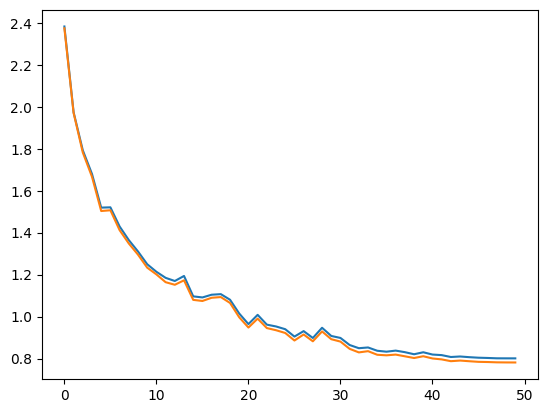

In [7]:
from utils import plot_ray_results
plot_ray_results(results=result, metrics_names = ['rmse_val','rmse_train'])

In [13]:
checkpoint_data = torch.load(os.path.join(result.checkpoint.path,"model.pt"))

model_path = r"./Trained_model/EMS_ANN_v2.pt"
torch.save(checkpoint_data, model_path)

## Test dataset performance

In [8]:
# position unit mm, current unit Ampere
sparsity = 1
Current_position_test =data[train_file_num:, ::sparsity, ::sparsity, ::sparsity, :15].reshape(-1,15) 
# B field unit mT
Bfield_test = data[train_file_num:, ::sparsity, ::sparsity, ::sparsity,15:].reshape(-1,3)

num_sample = Current_position_test.shape[0]
print('position shape', Current_position_test.shape)
print('Bfield shape', Bfield_test.shape)

# construct dataset
test_set = eMNS_Dataset(
    x=Current_position_test,
    y=Bfield_test
)
test_set.test_norm_ANN(extremes=extremes, boundary_index=12)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=train_loop_config['batch_size'],
    shuffle=False)


position shape torch.Size([4260060, 15])
Bfield shape torch.Size([4260060, 3])


In [14]:
from utils import predict_check_rmse_ANN, check_rmse_ANN
from Training_loop_v2 import construct_model_ANN 

model_path = r"./Trained_model/EMS_ANN_v2.pt"
model = torch.load(model_path)['model']

prediction, rmse, mse, Rsquare = predict_check_rmse_ANN(test_loader, model,config=train_loop_config)
# check_rmse_ANN(test_loader, model, device, extremes[4], extremes[5])

Got rmse 0.8505653142929077, num_samples 4260060


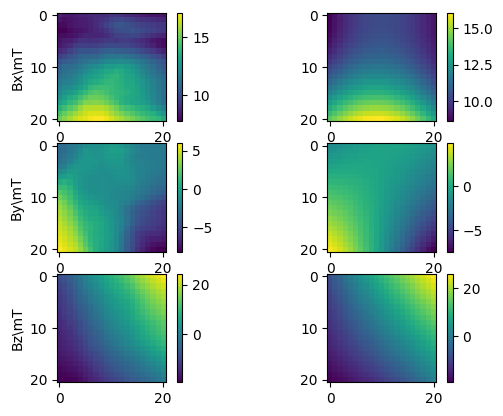

In [12]:
import matplotlib.pyplot as plt
import numpy as np
B_est = prediction.reshape(-1, grid_size, grid_size, grid_size, 3)
Bfield_test = Bfield_test.reshape(-1, grid_size, grid_size, grid_size, 3)

# B_est = prediction.reshape(-1, 6, 6, 6, 3)
# Bfield_test = Bfield_test.reshape(-1, 6, 6, 6, 3)

current_index=3
z_plane_index= 5
# fig, ax = plt.subplots(3, 2)
# fig.tight_layout(h_pad=2)
fig = plt.figure()
ylables=['Bx\mT','By\mT','Bz\mT']
# fig.tight_layout(pad=0.4, w_pad=0, h_pad=0)
for i in range(1,4):
    plt.subplot(3,2,2*i-1)
    plt.imshow(B_est[current_index,:,:,z_plane_index,i-1])    
    plt.colorbar()
    plt.ylabel(ylables[i-1])
    plt.subplot(3,2,2*i)
    plt.imshow(Bfield_test[current_index,:,:,z_plane_index,i-1])
    plt.colorbar()
plt.show()